In [2]:
import tensorflow as tf
keras = tf.keras
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
%run ../src/acc_df.py
Ac = Acc_data('../data/cleaned/coll_coord.csv')
acc = Ac.get_all_coll() #['']

### 1. Turn it into a time series of weeks

Cut out 2003 and 2019:

In [5]:
acc_04_18 = acc[(acc['year'] != 2019) & (acc['year'] != 2003 )]

acc_wd = acc_04_18[['weekday','year','week','OBJECTID']].groupby(['year','week']).max()
acc_wd.head(2)

In [7]:
weeks_to_delete = acc_wd[acc_wd['week']==53]
weeks_to_delete

KeyError: 'week'

In [278]:
acc_w = acc_04_18[['year','week','OBJECTID']].groupby(['year','week']).count()
acc_w.rename({'OBJECTID': 'acc_nr'}, axis=1, inplace=True)
week_numbers_full = acc_w.reset_index()

Merge truncated end/beginning of year weeks:

In [268]:
acc_w.acc_nr.sum(), len(acc_w)

(198459, 786)

In [269]:
for index, row in weeks_to_merge.iterrows():
    print(acc_wd.loc[index])
    ind_next = (index[0]+1, 1)
    acc_w.loc[ind_next]['acc_nr'] += acc_w.loc[index]
    acc_w.drop([index], axis=0, inplace=True)

weekday         4
OBJECTID    19083
Name: (2004, 53), dtype: int64
weekday         5
OBJECTID    35083
Name: (2005, 52), dtype: int64
weekday         3
OBJECTID    94345
Name: (2009, 53), dtype: int64
weekday          4
OBJECTID    137965
Name: (2010, 52), dtype: int64
weekday          3
OBJECTID    170916
Name: (2015, 53), dtype: int64
weekday          5
OBJECTID    194718
Name: (2016, 52), dtype: int64


In [270]:
acc_w.acc_nr.sum(), len(acc_w)

(198459, 780)

In [271]:
week_numbers = acc_w.reset_index()

In [272]:
# week_numbers.index.values

In [273]:
week_numbers.tail(2)

,year,week,acc_nr
778,2018,51,234
779,2018,52,150


In [274]:
acc_nr_bw = week_numbers.acc_nr.values #[:100]

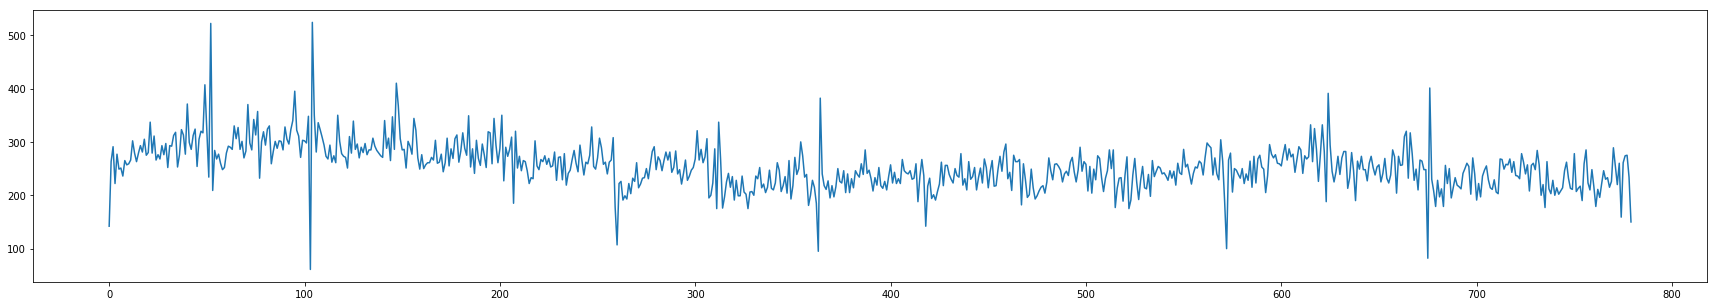

In [279]:
fig, ax = plt.subplots(figsize=(30,5))
ax.plot(week_numbers.index.values, acc_nr_bw)

##### For comparison: here is how it looked like before the merge:

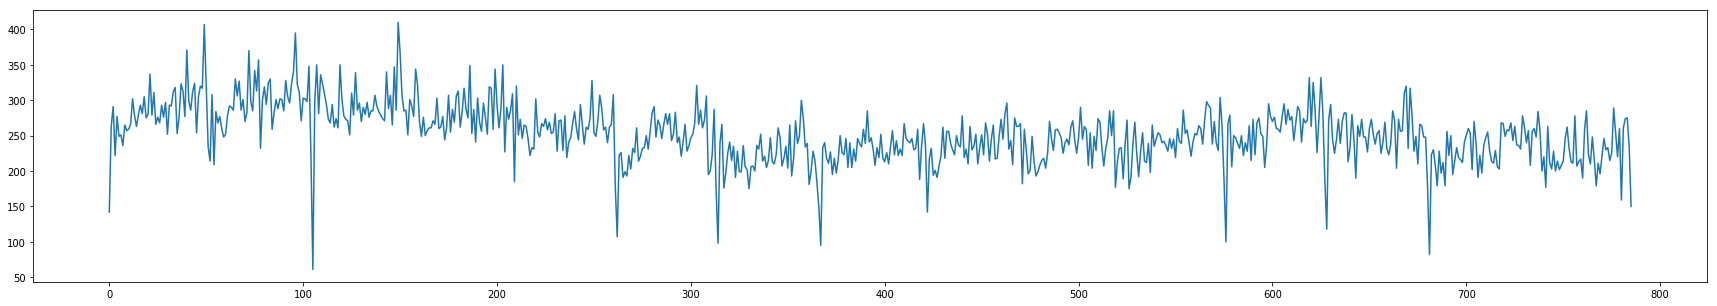

In [281]:
acc_nr_bw_full = week_numbers_full.acc_nr.values
fig, ax = plt.subplots(figsize=(30,5))
ax.plot(week_numbers_full.index.values, acc_nr_bw_full)

#### Windowize and split

In [282]:
def windowize_data(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[indices, None]
    return x, y

In [283]:
# windowize_data(week_numbers.index.values,20)

In [284]:
def split_and_windowize(data, n_prev, fraction_test=0.3):
    n_predictions = len(data) - 2*n_prev
    
    n_test  = int(fraction_test * n_predictions)
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev)
    x_test, y_test = windowize_data(data[n_train:], n_prev)
    return x_train, x_test, y_train, y_test

In [285]:
acc_nr_bw

array([142, 263, 291, 222, 277, 249, 251, 236, 265, 257, 259, 266, 302,
       279, 263, 279, 293, 281, 305, 275, 280, 337, 279, 311, 266, 276,
       268, 293, 276, 297, 252, 293, 292, 312, 318, 253, 276, 323, 313,
       277, 371, 299, 286, 312, 324, 254, 305, 320, 317, 407, 320, 234,
       522, 209, 284, 268, 277, 260, 248, 252, 279, 292, 290, 286, 330,
       306, 327, 286, 301, 270, 283, 370, 298, 285, 342, 313, 357, 232,
       300, 319, 294, 324, 330, 259, 282, 301, 288, 302, 301, 285, 328,
       305, 296, 323, 340, 395, 322, 311, 271, 303, 302, 298, 348,  61,
       524, 350, 281, 336, 323, 309, 294, 273, 268, 294, 262, 274, 261,
       350, 301, 278, 273, 271, 251, 310, 279, 339, 286, 296, 270, 290,
       280, 297, 276, 285, 285, 307, 292, 284, 279, 274, 271, 340, 288,
       307, 265, 347, 286, 410, 368, 306, 285, 286, 251, 301, 292, 277,
       344, 322, 270, 249, 276, 250, 257, 261, 261, 271, 266, 303, 260,
       262, 277, 244, 261, 307, 255, 287, 269, 306, 313, 262, 28

In [286]:
n_prev = 10
x_train, x_test, y_train, y_test = split_and_windowize(acc_nr_bw,n_prev,fraction_test=0.1)

In [287]:
x_train[320]

array([[191],
       [228],
       [199],
       [199],
       [236],
       [206],
       [202],
       [175],
       [206],
       [207]])

In [288]:
y_train[320]

200

#### Model

In [293]:
model = keras.Sequential()
model.add(keras.layers.LSTM(32, input_shape=(n_prev, 1), return_sequences=True))
model.add(keras.layers.LSTM(32, return_sequences=False))
model.add(keras.layers.Dense(1, activation='softmax'))
model.compile(optimizer='adam',
              loss='mse')

In [294]:
model.fit(x_train, y_train, batch_size=60, epochs=100)

Train on 674 samples
Epoch 1/100
674/674 [==============================] - 1s 2ms/sample - loss: 67855.2507
Epoch 2/100
674/674 [==============================] - 0s 127us/sample - loss: 67855.2493
Epoch 3/100
674/674 [==============================] - 0s 126us/sample - loss: 67855.2499
Epoch 4/100
674/674 [==============================] - 0s 127us/sample - loss: 67855.2515
Epoch 5/100
674/674 [==============================] - 0s 127us/sample - loss: 67855.2510
Epoch 6/100
674/674 [==============================] - 0s 127us/sample - loss: 67855.2504
Epoch 7/100
674/674 [==============================] - 0s 125us/sample - loss: 67855.2502
Epoch 8/100
674/674 [==============================] - 0s 128us/sample - loss: 67855.2506
Epoch 9/100
674/674 [==============================] - 0s 130us/sample - loss: 67855.2511
Epoch 10/100
674/674 [==============================] - 0s 125us/sample - loss: 67855.2497
Epoch 11/100
674/674 [==============================] - 0s 120us/sample - loss: 

In [291]:
y_pred = model.predict(x_test)
y_pred[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

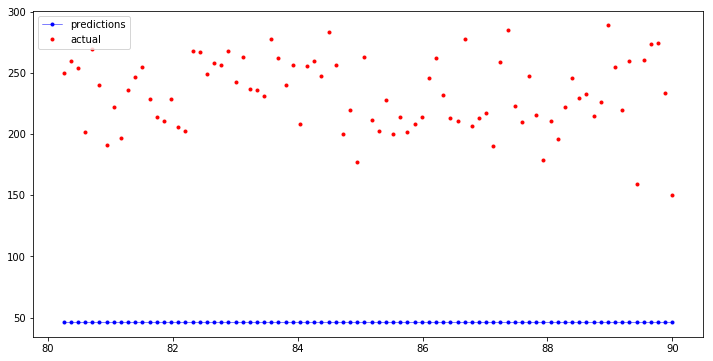

In [163]:
n_pts = len(acc_nr_bw)
t = np.linspace(0, 15 * 6, n_pts)
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t[-len(y_test):], y_pred, 'b.-', label='predictions', lw=0.5)
ax.plot(t[-len(y_test):], y_test, 'r.', label='actual')
ax.legend()